In [1]:
import torch
import numpy as np
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from string import punctuation
from torchvision import transforms
import torch.nn as nn

In [2]:
def read(path):
    file = open(path, encoding='utf8')
    lines = [line for line in file.readlines()]
    file.close()
    return lines

In [3]:
train_negative = 'train_negative_tokenized.txt'
train_neural = 'train_neutral_tokenized.txt'
train_positive = 'train_neutral_tokenized.txt'

In [4]:
negative = read(train_negative)
neural = read(train_neural)
positive = read(train_negative)

In [5]:
train_set = negative + neural + positive

# bỏ những dòng trống
train_set = [i for i in train_set if i != '\n']
size = len(train_set)

# đưa tất cả về chữ thường
for i in range(size):
    train_set[i] = train_set[i].lower()

# bỏ các ký tự unicode
for i in range(size):
    train_set[i] = train_set[i].replace('\ufeff', '').replace('\xa0', '').replace('\u200e', '').replace('\u200b', '').replace('\n', '')

# bỏ các chuỗi mặt cười
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])

# bỏ các chuỗi '...'
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])


In [6]:
vocab = Counter()

for i, sentence in enumerate(train_set):
    train_set[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        vocab.update([word]) # cập nhật số lần xuất hiện của word
        train_set[i].append(word)

In [7]:
for k in punctuation:
    del vocab[k]

In [8]:
vocab_ = sorted(vocab, key=vocab.get, reverse=True) # sắp xếp theo thứ tự tần suất xuất hiện giảm dần

In [9]:
w2i = {w:i+1 for i,w in enumerate(vocab)} # w2i[word] ->  mức độ xuất hiện word trong corpus
# (1 là xuất hiện nhiều nhất, số 0 để padding)
i2w = {i+1:w for i,w in enumerate(vocab)}

In [10]:
train_set_vct = np.empty_like(train_set)
for i, sentence in enumerate(train_set):
    train_set_vct[i] = [w2i[word] if word in w2i else 0 for word in sentence] # thay từ bằng w2i của từ, nếu không trong corpus -> 0

In [11]:
count = np.zeros(len(train_set_vct))
for s in train_set_vct:
    count[len(s)] += 1

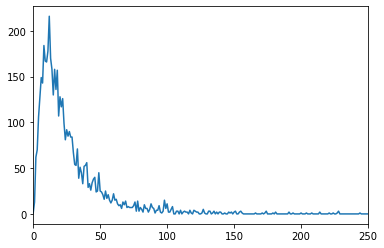

In [12]:
plt.plot(count)
plt.xlim((0,250))
plt.show() # phân bố độ dài các câu

In [13]:
normalized_len = 150 # đa số câu đều < 150, chuẩn hóa độ dài câu về 150

In [14]:
def normalize_length(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)
    
    for i, review in enumerate(sentences):
        review_len = len(review)
        
        if review_len <= seq_length: # ngắn hơn seq_length -> chèn thêm 0 vào đầu
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length: # dài hơn -> chỉ lấy <seq_length> số đầu tiên
            new = review[0:seq_length]
        
        features[i] = np.array(new)
    return features

In [15]:
train_set_vct_normalized = normalize_length(train_set_vct, normalized_len)

In [16]:
labels = np.ones(len(train_set_vct_normalized))
labels[:1700] = -1 # negative
labels[1700:3400] = 0 # neural

In [37]:
class TokenizedWords(torch.utils.data.Dataset):
    def __init__(self, train_set_vct_normalized, labels):
        self.train_set_vct_normalized = train_set_vct_normalized
        self.labels = labels
    
    def __len__(self):
        return len(self.train_set_vct_normalized)

    def __getitem__(self, idx):
        item = torch.from_numpy(self.train_set_vct_normalized[idx])
        label = torch.tensor(self.labels[idx])

        return item, label


In [38]:
train_data = TokenizedWords(train_set_vct_normalized, labels)

In [39]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=100)

In [40]:
itr = iter(train_loader)
sentences, ground_truth = next(itr)
print(sentences, ground_truth)

tensor([[   0,    0,    0,  ..., 2656,  152,    0],
        [   0,    0,    0,  ...,   93,  506,    0],
        [   0,    0,    0,  ...,  121,    0,    0],
        ...,
        [   0,    0,    0,  ..., 4233, 4234,    0],
        [   0,    0,    0,  ...,   36,  155,  302],
        [   0,    0,    0,  ...,   14, 1481,  278]], dtype=torch.int32) tensor([ 1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,
         0., -1.,  0., -1., -1., -1.,  1., -1.,  0.,  1.,  0., -1., -1., -1.,
        -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  0.,  0.,  0., -1.,  0.,
         0.,  1., -1.,  1.,  1., -1.,  0.,  0.,  1., -1.,  0., -1., -1.,  1.,
        -1., -1., -1.,  0.,  1.,  0., -1.,  1.,  1.,  1., -1.,  0.,  1., -1.,
        -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  0.,  1.,  0., -1.,  1.,  1.,
        -1.,  0.,  0., -1.,  1.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,
         0.,  1.], dtype=torch.float64)


In [45]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [46]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model = SentimentNet(vocab_size, output_dim, embedding_dim, hidden_dim, no_layers)
print(model)

SentimentNet(
  (embedding): Embedding(8933, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [47]:
batch_size = 100
h = model.init_hidden(batch_size)
h = tuple([e.data for e in h])
out, h = model(sentences, h)

In [50]:
out

tensor([0.5055, 0.4945, 0.4978, 0.4993, 0.5028, 0.4876, 0.4974, 0.5024, 0.5065,
        0.4948, 0.4816, 0.4847, 0.4988, 0.4960, 0.4933, 0.4900, 0.4899, 0.4876,
        0.5112, 0.4974, 0.5005, 0.4932, 0.4963, 0.5030, 0.4986, 0.4924, 0.4985,
        0.4989, 0.4957, 0.4934, 0.4903, 0.4951, 0.4856, 0.4936, 0.4923, 0.4870,
        0.4932, 0.4933, 0.4950, 0.4897, 0.4820, 0.4916, 0.4916, 0.4874, 0.4849,
        0.4927, 0.4993, 0.5064, 0.5048, 0.4978, 0.5025, 0.4870, 0.4961, 0.5046,
        0.4932, 0.5009, 0.4981, 0.4923, 0.4889, 0.4900, 0.5022, 0.4985, 0.5003,
        0.4899, 0.5062, 0.5055, 0.5020, 0.4941, 0.4936, 0.5017, 0.4958, 0.4979,
        0.4902, 0.5004, 0.4922, 0.4945, 0.4992, 0.4910, 0.4985, 0.4926, 0.5076,
        0.4946, 0.4847, 0.4946, 0.4928, 0.4929, 0.4961, 0.5014, 0.4932, 0.4946,
        0.4848, 0.4965, 0.4984, 0.4862, 0.4941, 0.4973, 0.4949, 0.4897, 0.4944,
        0.5012], grad_fn=<SelectBackward>)

In [51]:
out.shape

torch.Size([100])